In [9]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS

from neuralforecast.losses.numpy import mae, mse

from nixtlats import TimeGPT

%matplotlib inline

In [10]:
with open("data/timegpt_api_key.txt", 'r') as file:
        API_KEY = file.read()

In [15]:
df = pd.read_csv('data/daily_min_temp.csv')
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [16]:
df['unique_id'] = 0
df = df.rename(columns={"Date": "ds", "Temp": "y"})

df = df[['unique_id', 'ds', 'y']]

df.head()

,unique_id,ds,y
0,0,1981-01-01,20.7
1,0,1981-01-02,17.9
2,0,1981-01-03,18.8
3,0,1981-01-04,14.6
4,0,1981-01-05,15.8


In [17]:
# Find the date range from the minimum to the maximum date
date_range = pd.date_range(start=df['ds'].min(), end=df['ds'].max())

# Find the missing dates by subtracting the dates in the DataFrame from the full date range
missing_dates = date_range[~date_range.isin(df['ds'])]

# Convert missing dates to a list or DataFrame as needed
missing_dates_list = missing_dates.tolist()

missing_dates_list

[]

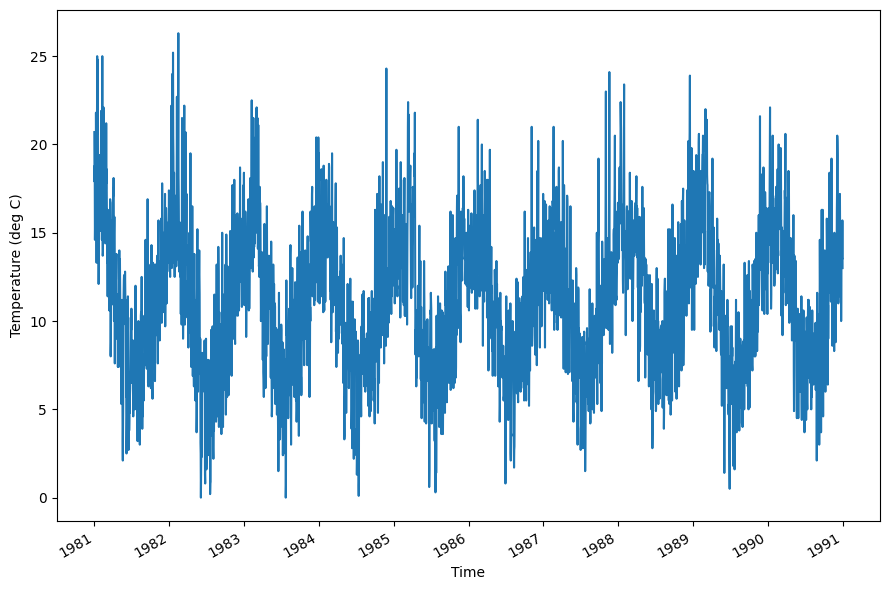

In [18]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(df['ds'], df['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (deg C)')

fig.autofmt_xdate()
plt.tight_layout()

## Modeling 

### TimeGPT 

In [19]:
train = df[:-365]
test = df[-365:]

print(train.shape)
print(test.shape)

(3287, 3)
(365, 3)


In [20]:
timegpt = TimeGPT(token=API_KEY)

timegpt_preds_df = timegpt.forecast(
    df=train,
    h=365,
    finetune_steps=10,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

timegpt_preds_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT
0,0,1990-01-01,14.286537
1,0,1990-01-02,14.032524
2,0,1990-01-03,13.493847
3,0,1990-01-04,13.032795
4,0,1990-01-05,13.032085


### Other models 

In [21]:
horizon = 365

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=30),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=30)]

Global seed set to 1
Global seed set to 1


In [22]:
nf = NeuralForecast(models=models, freq='D')

In [23]:
preds_df = nf.cross_validation(df=df, step_size=horizon, n_windows=1)

Epoch 29: 100%|█████████████████| 1/1 [00:00<00:00,  5.49it/s, v_num=34, train_loss_step=3.030, train_loss_epoch=3.050]
Validation: 0it [00:00, ?it/s]
Epoch 29: 100%|█████████████████| 1/1 [00:00<00:00,  5.46it/s, v_num=36, train_loss_step=3.500, train_loss_epoch=3.520]
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.01it/s]


In [24]:
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,y
0,0,1990-01-01,1989-12-31,12.608283,11.062569,14.8
1,0,1990-01-02,1989-12-31,11.990847,10.673495,13.3
2,0,1990-01-03,1989-12-31,12.123895,10.935327,15.6
3,0,1990-01-04,1989-12-31,12.755013,11.253635,14.5
4,0,1990-01-05,1989-12-31,12.299282,11.405057,14.3


In [25]:
preds_df['TimeGPT'] = timegpt_preds_df['TimeGPT']

preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,y,TimeGPT
0,0,1990-01-01,1989-12-31,12.608283,11.062569,14.8,14.286537
1,0,1990-01-02,1989-12-31,11.990847,10.673495,13.3,14.032524
2,0,1990-01-03,1989-12-31,12.123895,10.935327,15.6,13.493847
3,0,1990-01-04,1989-12-31,12.755013,11.253635,14.5,13.032795
4,0,1990-01-05,1989-12-31,12.299282,11.405057,14.3,13.032085


## Evaluation 

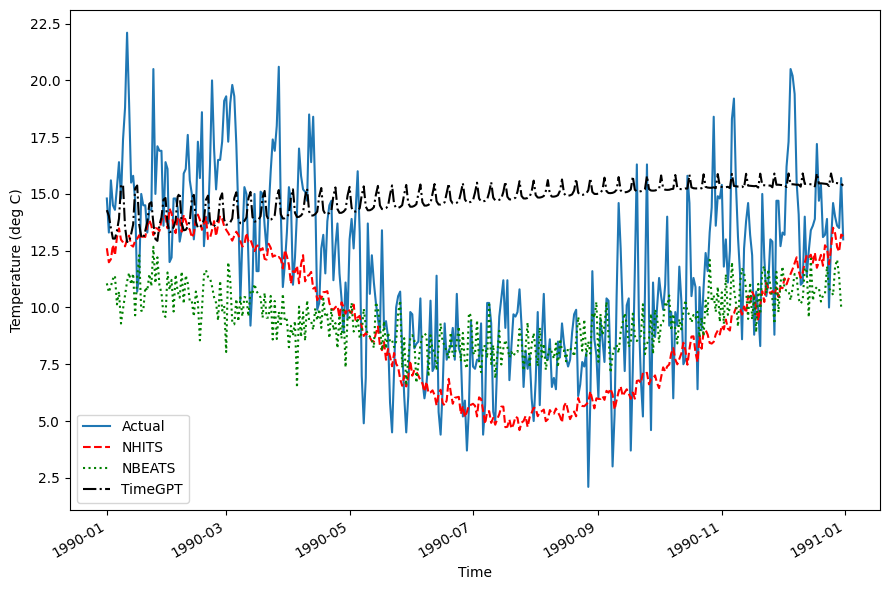

In [26]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(preds_df['ds'], preds_df['y'], label='Actual')
ax.plot(preds_df['ds'], preds_df['NHITS'], label='NHITS', ls='--', color='red')
ax.plot(preds_df['ds'], preds_df['NBEATS'], label='NBEATS', ls=':', color='green')
ax.plot(preds_df['ds'], preds_df['TimeGPT'], label='TimeGPT', ls='-.', color='black')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (deg C)')

fig.autofmt_xdate()
plt.tight_layout()

In [27]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'TimeGPT': [mae(preds_df['TimeGPT'], preds_df['y']), mse(preds_df['TimeGPT'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimeGPT
mae,2.790446,3.120972,4.291825
mse,11.818198,15.635011,26.698337
